In [1]:
# 전체 코드 예시: Pandas DataFrame에 저장된 데이터를 사용하여 GAN을 학습시키는 예제
"""
코드 : https://github.com/u7javed/Conditional-WGAN-GP/blob/master/train.py
"""
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import time

from sklearn import preprocessing

import os
import random
import warnings
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 동일 결과 재생성을 위한 랜덤성 고정
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
print('Using device:', device)

Using device: cuda


### 전체 원재료코드(JRCODE) 및 공정종류(PUTGB) 인코딩 테이블 및 nast 딕셔너리 생성

In [3]:
combined_df = pd.read_csv(f'./final_dataset/combined_pps_data_fin.csv')
combined_df.head()

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE017A,EE011G,EE023A,CB003A,CB001C,CB011B,CD023B,CD013A,CD011A,CD005A,FF005A,NN031A,OP004A,OP005A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.523810,27.619048,41.428571,2.380952,0.476190,0.476190,0.476190,0.714286,0.714286,0.714286,100.000000,54.285714,38.095238,19.047619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,74.0,1.100,151.0,245.0
1,0504PA001_T001,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,C1,CA019C,CA013A,CC022A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
2,0504PA001_T001,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
3,0504PA001_T002,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
tmp_df = combined_df.copy()
tmp_df = tmp_df.fillna(np.nan)

# 원재료 코드 리스트 생성
JRCODE_ls = []
jrcode_col_ls = [col for col in tmp_df.columns if 'JRCODE' in col]
for jrcode_col in jrcode_col_ls:
    JRCODE_ls += tmp_df[jrcode_col].unique().tolist()
    JRCODE_ls = list(set(JRCODE_ls))
    JRCODE_ls = [x for x in JRCODE_ls if str(x) != 'nan']

# 이상 원재료코드 리스트 생성
rm_jrcode_ls = [jr for jr in JRCODE_ls if 'C1' in jr]

for rm_jr in rm_jrcode_ls:
    JRCODE_ls.remove(rm_jr)

# 원재료 코드 테이블 생성
JRCODE_df = pd.DataFrame({'JRCODE':JRCODE_ls}).sort_values('JRCODE').reset_index(drop=True)
JRCODE_df['JR_ID'] = JRCODE_df.index
JRCODE_df = JRCODE_df[['JRCODE','JR_ID']]

# 공정 타입 테이블 생성 (1-6)
PUTGB_df = pd.DataFrame({'PUTGB':['P','CH','CB','OA','OB','F']}).reset_index(drop=True)
PUTGB_df['PUTGB_ID'] = PUTGB_df.index + 1 # (1-6)
PUTGB_df.columns = ['PUTGB_ID','PUTGB']

display(f'전체 원재료코드 수 : {len(JRCODE_df)}, 공정종류 수 : {len(PUTGB_df)}')

# 원재료 코드 dictionary 생성
JRCODE_dict = {}
for idx, row in JRCODE_df.iterrows():
    JRCODE_dict[row['JRCODE']] = row['JR_ID']

# 공정 타입 dictionary 생성
PUTGB_dict = {}
for idx, row in PUTGB_df.iterrows():
    PUTGB_dict[row['PUTGB']] = row['PUTGB_ID']

# nan을 마지막으로 추가
JRCODE_dict['0'] = len(JRCODE_dict)
PUTGB_dict['0'] = len(PUTGB_dict)

display(f'NAN포함!! JRCODE 딕셔너리 길이: {len(JRCODE_dict)}, PUTGB 딕셔너리 길이: {len(PUTGB_dict)}')

'전체 원재료코드 수 : 833, 공정종류 수 : 6'

'NAN포함!! JRCODE 딕셔너리 길이: 834, PUTGB 딕셔너리 길이: 7'

### 이상치 원재료 포함 데이터 제거 및 원재료 코드 정수화, 변수 타입별 데이터 정규화

In [5]:
# 이상한 원재료를 갖는 데이터 제거
filtered_idx_ls = []
for rm_jrcode in rm_jrcode_ls:
    for col in jrcode_col_ls:
        tmp_tmp_df = tmp_df[~(tmp_df[col].isna())]
        filtered_idx_ls += tmp_tmp_df[(tmp_tmp_df[col].str.contains(rm_jrcode))].index.tolist()

        filtered_idx_ls = list(set(filtered_idx_ls))

tmp_df = tmp_df.iloc[[idx for idx in tmp_df.index if idx not in filtered_idx_ls]].reset_index(drop=True)
tmp_df = tmp_df.fillna(0)

# 원재료 코드 정수로 변환
data_df = tmp_df.copy()
for i in range(1, 26):
    data_df['JRCODE'+str(i)] = data_df['JRCODE'+str(i)].apply(lambda x: int(JRCODE_dict[str(x)]))
    data_df['PHR'+str(i)].fillna(0, inplace=True)

data_df

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,394,382,405,64,61,78,162,147,144,132,644,729,783,786,833,833,833,833,833,833,833,833,833,833,833,9.523810,27.619048,41.428571,2.380952,0.476190,0.476190,0.476190,0.714286,0.714286,0.714286,100.000000,54.285714,38.095238,19.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,74.0,1.100,151.0,245.0
1,0504PA001_T001,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600,273,314,132,731,753,757,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
2,0504PA001_T002,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600,273,314,132,731,753,757,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,100.000000,10.000000,1.000000,2.

In [6]:
# MIN-MAX(0-1) 스케일러 생성 및 데이터 변환

# 입력변수 종류별 스케일러 저장
scaler_data_df = data_df.copy()
mColNmLs = ['RPM', 'TEMP', 'TIME', 'JUK', 'JRCODE', 'PHR', 'PUTGB']
scalerDic = {}
for mCol in mColNmLs:
    cols = [col for col in scaler_data_df.columns if (mCol in col) & ('_' not in col)]
    data = np.array(scaler_data_df[cols].values.tolist()).flatten().reshape(-1,1)
    # scalerDic[mCol] = preprocessing.StandardScaler().fit(data)
    scalerDic[mCol] = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(data)
    print(f'cols: {mCol}\tdata# : {len(data)}\tcol# : {len(cols)}\tMIN: {min(data)}\tMAX: {max(data)}')

# 출력변수별 스케일러 저장
trgColNmLs = ['HS_TEMP','HS_TIME','SG_TEMP','SG_TIME','TS_TEMP','TS_TIME','EB_TEMP','EB_TIME','HS_VAL','SG_VAL','TS_VAL','EB_VAL']
for trgCol in trgColNmLs:
    data = np.array(scaler_data_df[trgCol].values.tolist()).flatten().reshape(-1,1)
    # scalerDic[trgCol] = preprocessing.StandardScaler().fit(data)
    scalerDic[trgCol] = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(data)
    print(f'cols: {trgCol}\tdata# : {len(data)}\tcol# : {1}\tMIN: {min(data)}\tMAX: {max(data)}')

# 입력변수 종류별 스케일링
for mCol in mColNmLs:
    cols = [col for col in scaler_data_df.columns if (mCol in col) & ('_' not in col)]
    for col in cols:
        scaler_data_df[col] = scalerDic[mCol].transform(np.array(scaler_data_df[col]).reshape(-1, 1))

# 출력변수별 스케일링
for trgCol in trgColNmLs:
    scaler_data_df[trgCol] = scalerDic[trgCol].transform(np.array(scaler_data_df[trgCol]).reshape(-1, 1))

scaler_data_df

cols: RPM	data# : 700557	col# : 23	MIN: [0.]	MAX: [3882.]
cols: TEMP	data# : 700557	col# : 23	MIN: [0.]	MAX: [6551.1]
cols: TIME	data# : 700557	col# : 23	MIN: [0.]	MAX: [999.9]
cols: JUK	data# : 700557	col# : 23	MIN: [0.]	MAX: [6856.]
cols: JRCODE	data# : 761475	col# : 25	MIN: [0]	MAX: [833]
cols: PHR	data# : 761475	col# : 25	MIN: [0.]	MAX: [100.]
cols: PUTGB	data# : 761475	col# : 25	MIN: [0.]	MAX: [6.]
cols: HS_TEMP	data# : 30459	col# : 1	MIN: [0.]	MAX: [195.]
cols: HS_TIME	data# : 30459	col# : 1	MIN: [0.]	MAX: [30.]
cols: SG_TEMP	data# : 30459	col# : 1	MIN: [0.]	MAX: [195.]
cols: SG_TIME	data# : 30459	col# : 1	MIN: [0.]	MAX: [30.]
cols: TS_TEMP	data# : 30459	col# : 1	MIN: [0.]	MAX: [195.]
cols: TS_TIME	data# : 30459	col# : 1	MIN: [0.]	MAX: [30.]
cols: EB_TEMP	data# : 30459	col# : 1	MIN: [0.]	MAX: [195.]
cols: EB_TIME	data# : 30459	col# : 1	MIN: [0.]	MAX: [30.]
cols: HS_VAL	data# : 30459	col# : 1	MIN: [23.]	MAX: [98.]
cols: SG_VAL	data# : 30459	col# : 1	MIN: [0.096]	MAX: [74.]
cols: T

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.054022,-0.082833,-0.027611,-0.846339,-0.853541,-0.812725,-0.611044,-0.647059,-0.654262,-0.683073,0.546218,0.750300,0.879952,0.887155,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,-0.809524,-0.447619,-0.171429,-0.952381,-0.990476,-0.990476,-0.990476,-0.985714,-0.985714,-0.985714,1.000000,0.085714,-0.238095,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.743590,-0.333333,0.743590,-0.333333,0.743590,-0.333333,0.743590,-0.333333,0.360000,-0.972830,-0.786172,-0.937805
1,0504PA001_T001,LAB,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.440576,-0.344538,-0.246098,-0.683073,0.755102,0.807923,0.817527,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000

In [32]:
class DenseBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DenseBlock, self).__init__()
        self.dense = nn.Linear(in_dim, out_dim)
        # self.leRelu = nn.LeakyReLU(0.2)
        self.leRelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.leRelu(self.dense(x))
     
# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self, input_size, condition_size):
        super(Discriminator, self).__init__()

        self.linear1 = DenseBlock(input_size + condition_size, 512)
        self.linear2 = DenseBlock(512, 128)
        self.linear3 = DenseBlock(128, 32)
        self.linear4 = nn.Linear(32, 1)
        self.dout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.dout(self.linear1(x))
        # x = self.dout(self.linear2(x))
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return self.sigmoid(x)

# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, noise_size, output_size, condition_size):
        super(Generator, self).__init__()

        self.linear1 = DenseBlock(noise_size + condition_size, 128)
        self.linear2 = DenseBlock(128, 32)
        self.linear3 = DenseBlock(32, 128)
        self.linear4 = DenseBlock(128, 256)
        self.linear5 = DenseBlock(256, 512)
        self.linear6 = nn.Linear(512, output_size)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        x = self.linear6(x)
        return self.tanh(x)
    
def gradient_penalty(discriminator, real_samples, fake_samples, label_encoded):
        # Random weight term for interpolation between real and fake samples
        # alpha = tf.random.normal([real.shape[0], 1], 0.0, 1.0)
        alpha = torch.Tensor(np.random.random((real_samples.size(0), 1)))#.to(device)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = discriminator(torch.cat((interpolates, label_encoded), 1))
        fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0)#.to(device)
        fake.requires_grad = False
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )
        gradients = gradients[0].view(gradients[0].size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

In [22]:
# # Discriminator 모델 정의
# class Discriminator(nn.Module):
#     def __init__(self, input_size, condition_size):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_size + condition_size, 128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(128, 32),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(32, 16),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
    
#     def forward(self, x):
#         return self.model(x)

# # Generator 모델 정의
# class Generator(nn.Module):
#     def __init__(self, input_size, output_size, condition_size):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_size + condition_size, 128),
#             nn.LeakyReLU(0.2, inplace=True),
#             # nn.BatchNorm1d(64),
#             nn.Linear(128, 32),
#             nn.LeakyReLU(0.2, inplace=True),
#             # nn.BatchNorm1d(64),
#             nn.Linear(32, 128),
#             nn.LeakyReLU(0.2, inplace=True),
#             # nn.BatchNorm1d(64),
#             nn.Linear(128, output_size),
#             # nn.Tanh(),
#         )
    
#     def forward(self, x):
#         return self.model(x)
    
# # For checking CGAN's validity in final step
# def check_condition(_generator, sample_num, target_labels, condition_size_ls, latent_size):
#     for i in np.arange(len(target_labels)):
#         test_label = torch.full((1, sample_num), target_labels[i]).squeeze(0)    
#         if i == 0:            
#             test_label_encoded = F.one_hot(test_label, num_classes=condition_size_ls[i]).to(device)
#         else:
#             test_label_encoded = torch.cat((test_label_encoded, F.one_hot(test_label, num_classes=condition_size_ls[i]).to(device)), 1)

#     # create noise(latent vector) 'z'
#     _z = torch.randn(sample_num, latent_size).to(device)
#     _z_concat = torch.cat((_z, test_label_encoded), 1)
#     generated_data = _generator(_z_concat)

#     return generated_data.detach()

# def gradient_penalty(discriminator, real_samples, fake_samples, label_encoded):
#         # Random weight term for interpolation between real and fake samples
#         # alpha = tf.random.normal([real.shape[0], 1], 0.0, 1.0)
#         alpha = torch.Tensor(np.random.random((real_samples.size(0), 1)))#.to(device)
#         # Get random interpolation between real and fake samples
#         interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
#         d_interpolates = discriminator(torch.cat((interpolates, label_encoded), 1))
#         fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0)#.to(device)
#         fake.requires_grad = False
#         # Get gradient w.r.t. interpolates
#         gradients = torch.autograd.grad(
#             outputs=d_interpolates,
#             inputs=interpolates,
#             grad_outputs=fake,
#             create_graph=True,
#             retain_graph=True,
#             only_inputs=True,
#         )
#         gradients = gradients[0].view(gradients[0].size(0), -1)
#         gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
#         return gradient_penalty

In [37]:
batch_size = 64
lr = 0.00005
num_epochs = 200
show_step = 10
latent_size_ = 100

stVal = 0
gp_weight = 5

tmp_data_df = scaler_data_df.copy()

criterion = nn.BCELoss()

# 대상
trg_yCols = ['HS_VAL','SG_VAL','TS_VAL','EB_VAL']

grNum_ls = []

for yCol in trg_yCols:
    nUniq = tmp_data_df[yCol].nunique()
    if nUniq < 100:
        grNum = nUniq//5
    else:
        grNum = min(50, nUniq//10)
    
    # print(f'groupNum : {grNum}')
    tmp_data_df[yCol+'_G'], cutBins = pd.qcut(tmp_data_df[yCol],grNum, labels=np.arange(stVal,stVal+grNum), retbins=True)
    grNum_ls.append(grNum)

# 필요없는 변수 제거 (그룹화한 결과는 존재)
tmp_data_df = tmp_data_df.drop(['ID','TYPE'] + trg_yCols, axis=1)
# batch_size 로 나눠지도록 나머지 버림
tmp_data_df = tmp_data_df.iloc[:-(len(tmp_data_df) % batch_size)]

# DataFrame을 PyTorch Tensor로 변환
data = torch.tensor(tmp_data_df.values, dtype=torch.float32)

# DataLoader 설정
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델, 옵티마이저, 손실 함수 설정
condition_size = sum(grNum_ls)                              # 조건 feature의 개수
input_size = len(tmp_data_df.columns) - len(trg_yCols)      # 입력 feature의 개수
output_size = input_size                                    # 출력 feature의 개수 (입력과 동일하게)
latent_size = latent_size_                                  # 잠재 공간의 크기

discriminator = Discriminator(input_size, condition_size)
generator = Generator(latent_size, output_size, condition_size)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

# 학습 시작
stTime = time.time()

gen_loss_trace = []
was_loss_trace = []

dis_real_loss_trace = []
dis_fake_loss_trace = []

dis_real_acc_trace = []
dis_fake_acc_trace = []

for epoch in range(num_epochs):

    gen_loss = 0
    dis_loss = 0
    was_loss = 0

    dis_real_loss = 0
    dis_fake_loss = 0

    dis_real_acc = 0
    dis_fake_acc = 0

    cnt = 0
    for n, (real_data,) in enumerate(dataloader):
        # batch_size = real_samples.size(0)

        real_data_labels = torch.ones((batch_size, 1))
        fake_data_labels = torch.zeros((batch_size, 1))

        x = real_data[:,:-len(trg_yCols)]
        labels = real_data[:,-len(trg_yCols):]

        """
        FOR CONDITIONAL GAN
        """
        for i in np.arange(len(trg_yCols)):
            # Encode label with 'one hot encoding'
            if i == 0:
                label_encoded = F.one_hot(labels[:,i].to(torch.int64), num_classes=grNum_ls[i]).squeeze(1)
            else:
                label_encoded = torch.cat((label_encoded, F.one_hot(labels[:,i].to(torch.int64), num_classes=grNum_ls[i]).squeeze(1)), 1)

        # concat real images with 'label encoded vector'
        real_data_concat = torch.cat((x, label_encoded), 1)

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # Initialize grad
        d_optimizer.zero_grad()

        # make fake data with generator & noise vector 'z'
        z = torch.randn(batch_size, latent_size)

        """
        FOR CONDITIONAL GAN
        """
        # concat noise vector z with encoded labels
        z_concat = torch.cat((z, label_encoded), 1)
        fake_data = generator(z_concat)
        fake_data_concat = torch.cat((fake_data, label_encoded), 1)

        output_real = discriminator(real_data_concat)
        output_fake = discriminator(fake_data_concat)

        # Calculate fake & real loss with generated images above & real images        
        real_loss = -torch.mean(output_real)
        fake_loss = torch.mean(output_fake)

        gp = gradient_penalty(discriminator, x, fake_data, label_encoded)

        d_loss = fake_loss - real_loss
        w_loss = (fake_loss + real_loss) + gp_weight*gp
        w_loss.backward()
        d_optimizer.step()

        d_real_acc = (output_real.round() == real_data_labels).float().sum()
        d_fake_acc = (output_fake.round() == fake_data_labels).float().sum()

        dis_real_acc += d_real_acc.item()/batch_size
        dis_fake_acc += d_fake_acc.item()/batch_size

        dis_real_loss += real_loss.item()/batch_size
        dis_fake_loss += fake_loss.item()/batch_size
        dis_loss += d_loss.item()/batch_size
        was_loss += w_loss.item()/batch_size

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # Initialize grad
        g_optimizer.zero_grad()

        # make fake data with generator & noise vector 'z'
        z = torch.randn(batch_size, latent_size)

        """
        FOR CONDITIONAL GAN
        """
        # concat noise vector z with encoded labels
        z_concat = torch.cat((z, label_encoded), 1)
        fake_data_concat = torch.cat((generator(z_concat), label_encoded), 1)

        # Compare result of discriminator with fake images & real labels
        # If generator deceives discriminator, g_loss will decrease
        g_loss = -torch.mean(discriminator(fake_data_concat))

        # Train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        gen_loss += g_loss.item()/batch_size

        cnt+=1
    dis_real_acc = dis_real_acc/cnt
    dis_fake_acc = dis_fake_acc/cnt

    # Show loss
    if epoch % show_step == 0:
        print(f"Epoch: {epoch:3.0f} Loss D.: {dis_loss:.5f}, Loss G.: {gen_loss:.5f}, Loss W.: {was_loss:.5f}, Real acc D.: {dis_real_acc:.5f}, Fake acc D.: {dis_fake_acc:.5f}, time: {(time.time() - stTime):.3f}s")
        stTime = time.time()

    gen_loss_trace.append(gen_loss)
    was_loss_trace.append(was_loss)
    
    dis_real_loss_trace.append(dis_real_loss)
    dis_fake_loss_trace.append(dis_fake_loss)

    dis_real_acc_trace.append(dis_real_acc)
    dis_fake_acc_trace.append(dis_fake_acc)

Epoch:   0 Loss D.: 9.25518, Loss G.: -4.86608, Loss W.: 30.38725, Real acc D.: 0.60539, Fake acc D.: 0.16780, time: 8.501s
Epoch:  10 Loss D.: 7.00036, Loss G.: -2.31981, Loss W.: -1.06452, Real acc D.: 0.67780, Fake acc D.: 0.99339, time: 79.497s
Epoch:  20 Loss D.: 6.62558, Loss G.: -2.06366, Loss W.: -1.39381, Real acc D.: 0.64641, Fake acc D.: 0.99158, time: 78.905s
Epoch:  30 Loss D.: 8.45822, Loss G.: -3.22721, Loss W.: -0.79020, Real acc D.: 0.88132, Fake acc D.: 0.75289, time: 80.564s
Epoch:  40 Loss D.: 7.33537, Loss G.: -2.68191, Loss W.: -1.24075, Real acc D.: 0.74069, Fake acc D.: 0.92539, time: 80.735s
Epoch:  50 Loss D.: 7.34903, Loss G.: -2.93961, Loss W.: -0.96466, Real acc D.: 0.67211, Fake acc D.: 0.81734, time: 81.182s
Epoch:  60 Loss D.: 7.26466, Loss G.: -2.78768, Loss W.: -1.19840, Real acc D.: 0.68635, Fake acc D.: 0.87332, time: 81.921s
Epoch:  70 Loss D.: 7.36200, Loss G.: -2.94090, Loss W.: -1.02373, Real acc D.: 0.69424, Fake acc D.: 0.82079, time: 85.141s
E

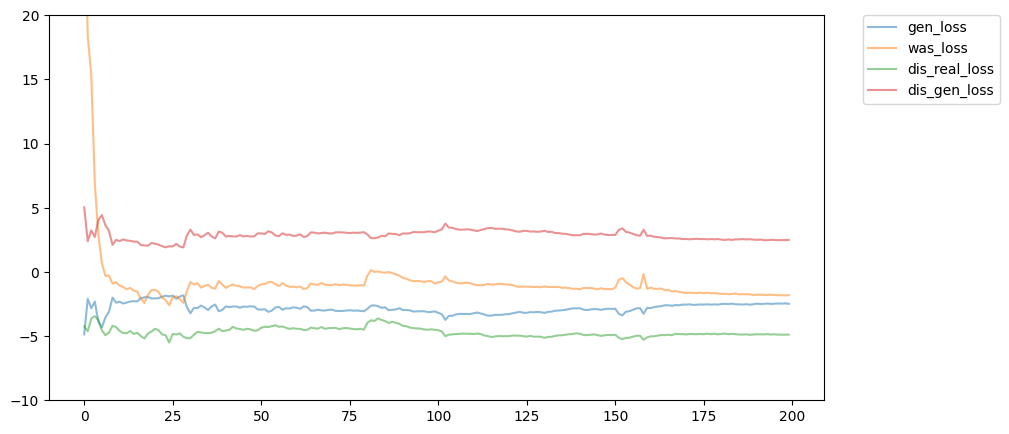

In [38]:
from matplotlib import pyplot as plt

sIdx = 0
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_trace[sIdx:], label='gen_loss', alpha=0.5)
plt.plot(was_loss_trace[sIdx:], label='was_loss', alpha=0.5)
plt.plot(dis_real_loss_trace[sIdx:], label='dis_real_loss', alpha=0.5)
plt.plot(dis_fake_loss_trace[sIdx:], label='dis_gen_loss', alpha=0.5)
plt.ylim(-10,20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

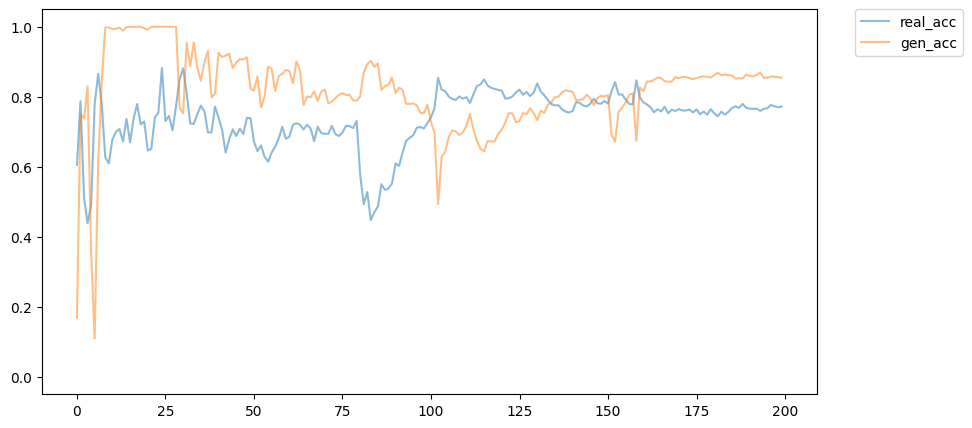

In [39]:
from matplotlib import pyplot as plt

sIdx = 0
plt.figure(figsize=(10, 5))
plt.plot(dis_real_acc_trace[sIdx:], label='real_acc', alpha=0.5)
plt.plot(dis_fake_acc_trace[sIdx:], label='gen_acc', alpha=0.5)
plt.ylim(-0.05, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [40]:
# For checking CGAN's validity in final step
def check_condition(generator, n_samples, trg_label_ls, grNum_ls, latent_size):

    for i in np.arange(len(trg_label_ls)):
        test_label = torch.full((1, n_samples), trg_label_ls[i]).squeeze(0)
        if i == 0:            
            test_label_encoded = F.one_hot(test_label, num_classes=grNum_ls[i]).to(device)
        else:
            test_label_encoded = torch.cat((test_label_encoded, F.one_hot(test_label, num_classes=grNum_ls[i]).to(device)), 1)

    # create noise(latent vector) 'z'c
    _z = torch.randn(n_samples, latent_size).to(device)
    if device.type == 'cuda':    
        _z_concat = torch.cat((_z, test_label_encoded), 1).cpu()
    else:
        _z_concat = torch.cat((_z, test_label_encoded), 1)
    
    return generator(_z_concat).detach()

In [41]:
trg_label_ls = [1, 1, 1, 1]

check_df = tmp_data_df[(tmp_data_df[trg_yCols[0]+'_G']==trg_label_ls[0])|(tmp_data_df[trg_yCols[1]+'_G']==trg_label_ls[1])
                   |(tmp_data_df[trg_yCols[2]+'_G']==trg_label_ls[2])|(tmp_data_df[trg_yCols[3]+'_G']==trg_label_ls[3])]

n_samples = len(check_df)
gen_samples = check_condition(generator, n_samples, trg_label_ls, grNum_ls, latent_size).numpy()
gen_df = pd.DataFrame(gen_samples, columns=tmp_data_df.columns[:-len(trg_label_ls)])
# display('gen:',gen_df.describe(),'ori:',tmp_data_df[tmp_data_df[yCol+'_G']==trg_label].describe())
display('ori:',check_df.describe(),'gen:',gen_df.describe())

'ori:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.0,4113.0,4113.0,4113.0,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.00000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000
mean,-0.946537,-0.944544,-0.944903,-0.944300,-0.945753,-0.945467,-0.961261,-0.961467,-0.962000,-0.953836,-0.951918,-0.925356,-0.806007,-0.720463,-0.640021,-0.594546,-0.596755,-0.595328,-0.729387,-0.857749,-0.985802,-0.996694,-0.999757,-0.975863,-0.981915,-0.981802,-0.980319,-0.974709,-0.971340,-0.965854,-0.965466,-0.965700,-0.965694,-0.969334,-0.976783,-0.983286,-0.986239,-0.989399,-0.989219,-0.988700,-0.990856,-0.996018,-0.997795,-0.999651,-0.999944,-0.999994,-0.859771,-0.957431,-0.954608,-0.946259,-0.945734,-0.965108,-0.945566,-0.955468,-0.956359,-0.955644,-0.954192,-0.963560,-0.963108,-0.977443,-0.970982,-0.966607,-0.948955,-0.968045,-0.977412,-0.990394,-0.999714,-0.999983,-1.0,-0.948988,-0.987402,-0.987178,-0.983462,-0.982194,-0.988359,-0.982414,-0.984008,

'gen:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4.113000e+03,4113.000000,4.113000e+03,4.113000e+03,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4.113000e+03,4113.000000,4.113000e+03,4.113000e+03,4113.000000,4.113000e+03,4113.0,4113.0,4.113000e+03,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4.113000e+03,4113.000000,4113.000000,4113.0,4113.0,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4.113000e+03,4113.0,4.113000e+03,4113.0,4113.0,4.113000e+03,4.113000e+03,4113.0,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4.113000e+03,4113.000000,4113.000000,4113.000000,4113.000000,4.113000e+03,4.113000e+03,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4.113000e+03,4113.000000,4113.000000,4113.0,4113.0,4113.0,4113.0,4113.0,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4.113000e+03,4.113000e+03,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000
mean,-0.995820,-0.900398,-0.986673,-0.995416,-0.995298,-0.990838,-0.992569,-0.978241,-0.956977,-0.970504,-0.999980,-0.999303,-0.997401,-0.998822,-0.999853,-0.999994,-0.999960,-0.999961,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.0,-0.998114,-0.990084,-0.999427,-0.999872,-0.996571,-0.994923,-0.988315,-0.999139,-0.997158,-0.971066,-0.970237,-0.999101,-0.999836,-1.000000e+00,-0.999999,-9.999998e-01,-1.000000e+00,-0.999960,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-0.995859,-0.960169,-0.995278,-0.818248,-0.934362,-0.996542,-0.975447,-0.994943,-0.993131,-0.848361,-0.978139,-0.999754,-0.997734,-0.998273,-0.999992,-0.999919,-0.999901,-1.000000e+00,-1.000000,-0.999492,-1.0,-1.0,-1.0,-0.916255,-0.999999,-0.993099,-0.999616,-0.999572,-0.999970,-0.999954,-0.999403,-0.999842,-0.999992

In [42]:
### 역스케일링과 실수값 반올림

tmp_gen_df = gen_df.copy()

# 입력변수 종류별 스케일링
for mCol in mColNmLs:
    cols = [col for col in scaler_data_df.columns if (mCol in col) & ('_' not in col)]
    for col in cols:
        tmp_gen_df[col] = scalerDic[mCol].inverse_transform(np.array(tmp_gen_df[col]).reshape(-1, 1))

# 출력변수별 스케일링
for trgCol in [col for col in trgColNmLs if col not in trg_yCols] :
    tmp_gen_df[trgCol] = scalerDic[trgCol].inverse_transform(np.array(tmp_gen_df[trgCol]).reshape(-1, 1))

tmp_gen_df = tmp_gen_df.round()

In [43]:
### 원재료코드와 공정순거에 대한 후처리

jr_colNm_ls = [col for col in tmp_gen_df.columns.tolist() if 'JRCODE' in col]
pt_colNm_ls = [col for col in tmp_gen_df.columns.tolist() if 'PUTGB' in col]

JRCODE_ls = list(JRCODE_dict.keys())

for col in jr_colNm_ls:
    idxs = tmp_gen_df[col].tolist()
    tmp_gen_df[col] = [JRCODE_ls[int(idx)] for idx in idxs]

tmp_gen_df[jr_colNm_ls] = tmp_gen_df[jr_colNm_ls].apply(lambda row: [ele for ele in row.values.tolist() if ele != '0'], axis=1).apply(lambda x: x + [np.nan] * (25 - len(x)) if isinstance(x, list) else x).tolist()
tmp_gen_df[pt_colNm_ls] = tmp_gen_df[pt_colNm_ls].apply(lambda row: [ele for ele in row.values.tolist() if ele != 0], axis=1).apply(lambda x: x + [np.nan] * (25 - len(x)) if isinstance(x, list) else x).tolist()
tmp_gen_df

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
0,5.0,204.0,39.0,6.0,10.0,9.0,1.0,0.0,49.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,52.0,0.0,1.0,9.0,3.0,34.0,1.0,9.0,150.0,28.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,23.0,3.0,164.0,66.0,0.0,32.0,1.0,1.0,145.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,433.0,0.0,8.0,1.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE070,EE053A,CB013,CA029A,CH010A,CA012,CV0011,EY014Z,EE007,PZ007A,OA001C,PE001A,PZ014,PZ014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,53.0,0.0,5.0,0.0,0.0,2.0,61.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,3.0,4.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.0,9.0,152.0,9.0,152.0,12.0,156.0,11.0
1,14.0,332.0,25.0,38.0,36.0,18.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,6.0,0.0,4.0,30.0,384.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,175.0,22.0,0.0,3.0,0.0,0.0,484.0,15.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,29.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ES002,EH003A,CB0051,CA032A,CV005B,CA013A,CJ005,EH003A,CD010A,OP008A,EB002A,CB016A,CA014A,CD026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,38.0,0.0,6.0,0.0,0.0,3.0,16.0,2.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,1.0,1.0,2.0,2.0,5.0,4.0,6.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.0,10.0,159.0,10.0,150.0,11.0,166.0,11.0
2,7.0,191.0,6.0,5.0,9.0,27.0,2.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.0,768.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,72.0,10.0,0.0,0.0,0.0,0.0,21.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EN020A,EN018,CA011,CA012,CB003A,CC009,EN008B,EB001,CD015A,OD003,CA002,CA001,CA001,CA003C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,86.0,0.0,0.0,0.0,15.0,74.0,1.0,16.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,5.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,9.0,167.0,9.0,157.0,8.0,170.0,9.0
3,0.0,5.0,0.0,1.0,0.0,0.0,14.0,131.0,1.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE046A,CV005,CA001B,CA024,CD013A,CA019,NN002A,NN774E,FF017A,PL003A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,78.